# U-Net Arquitectura Básica
Se construirá una arquitecutra U-Net básica para realizar segmentación semántica de Imágenes PAP de la base de datos HERLEV con células de cuello uterino. En particular, se hace la segmentación de citoplasma, tomando como referencia las máscaras presegmentadas por expertos. El tamaño de las imágenes de entrada será 128x128.

La estructura general UNET en jupyter se adaptó de:

[Estructura jupyter original](https://github.com/DavidReveloLuna/Semantic-Segmentation-Basic-U-Net)

En este estudio se presenta la idea orignal de UNET
[Paper Original](https://arxiv.org/pdf/1505.04597.pdf)

## 1. Importamos librerías

In [1]:
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
import random
# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import TensorBoard
import cv2
from tensorflow.keras.models import load_model


In [ ]:
#import tensorflow as tf

#print("Versión de tensorflow:{}".format(tf.__version__))
#print("GPU:{}".format(tf.test.gpu_device_name()))

## 2. Definimos configuración básica

In [2]:
width_shape, height_shape = 128, 128 # Tamaño de las imagenes de entrada
batch_size = 16
epochs = 20

## 3. Adecuamos el dataset

In [3]:
listaCelulas =  os.listdir('CELULAS/')
listaCelulasMask = os.listdir('MASCARAS/')
listaCelulasTest = os.listdir('PRUEBA/')


In [4]:
X = []
# recorremos las celulas de entrenamiento y las guardamos en un tensor
for celula in tqdm(listaCelulas):
    imagen = cv2.imread('CELULAS/'+celula)[:,:,:3]
    X.append(imagen)
X = np.asarray(X,dtype=np.uint8)
print('DATOS DE ENTRENAMIENTO:',X.shape)


100%|██████████| 927/927 [00:06<00:00, 139.31it/s]

DATOS DE ENTRENAMIENTO: (927, 128, 128, 3)


In [5]:
Y = []
# recorremos el directo con las máscaras y las guardamos en un tensor
for celula in tqdm(listaCelulasMask):
    imagen = cv2.imread('MASCARAS/'+celula)
    imagen = imagen[:,:,0]
    ret,imagen = cv2.threshold(imagen,100,255,cv2.THRESH_BINARY)
    imagen = np.asarray(imagen,dtype=np.bool_)
    imagen = np.expand_dims(imagen,axis=-1)
    Y.append(imagen)
Y = np.bool_(Y)
print('DATOS DE REFERENCIA:',Y.shape)

100%|██████████| 927/927 [00:07<00:00, 128.98it/s]

DATOS DE REFERENCIA: (927, 128, 128, 1)


In [6]:
prueba = []
# recorremos las celulas de entrenamiento y las guardamos en un tensor
for celula in tqdm(listaCelulasTest):
    imagen = cv2.imread('PRUEBA/'+celula)[:,:,:3]
    prueba.append(imagen)
prueba = np.asarray(prueba,dtype=np.uint8)
print('DATOS DE PRUEBA:',prueba.shape)

100%|██████████| 232/232 [00:02<00:00, 107.82it/s]

DATOS DE PRUEBA: (232, 128, 128, 3)


## 4. Mostramos algún elemento del dataset

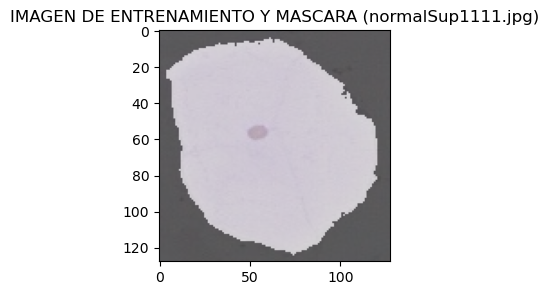

In [8]:
# Mostramos la imagen y su mascara asociada
num = random.randint(800,900)
plt.figure(figsize=(3,3))
plt.imshow(np.squeeze(X[num]),'gray')
plt.imshow(np.squeeze(Y[num]),alpha=0.5,cmap='gray')
plt.title('IMAGEN DE ENTRENAMIENTO Y MASCARA ('+listaCelulas[num]+')')
plt.show()

## 5. Creamos un modelo básico de U-Net

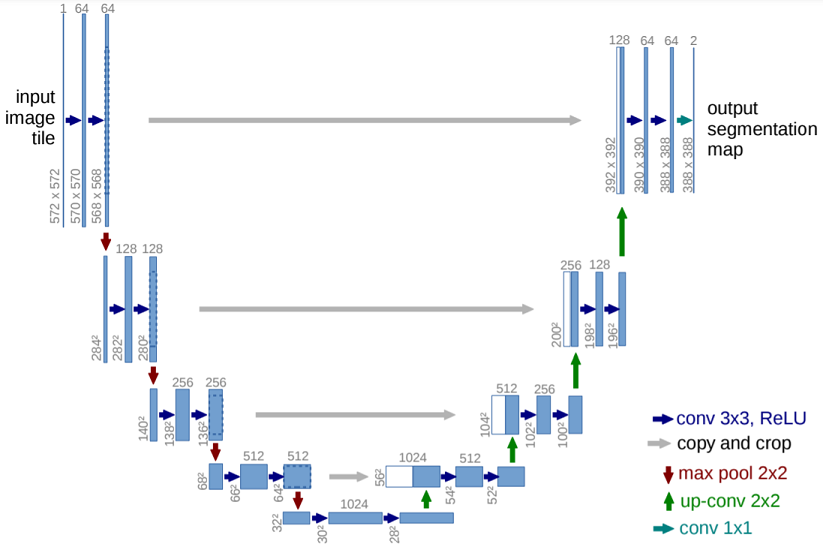

In [8]:
# Definimos la entrada al modelo
Image_input = Input((height_shape, width_shape,3))
Image_in = Lambda(lambda x: x / 255)(Image_input)

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Image_in)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)
 
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = Model(inputs=[Image_input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
______________________________________________________________________________________________

## 6. Entrenamos el modelo

In [10]:
#results = model.fit(X, Y, validation_split=0.1, batch_size=batch_size, epochs=epochs, callbacks=[tensorboard_callback])
results = model.fit(X, Y, validation_split=0.1, batch_size=batch_size, epochs=epochs)

Train on 933 samples, validate on 104 samples
Epoch 1/20
933/933 [==============================] - 206s 221ms/sample - loss: 0.6793 - accuracy: 0.6711 - val_loss: 0.5956 - val_accuracy: 0.7199
Epoch 2/20
933/933 [==============================] - 174s 186ms/sample - loss: 0.5154 - accuracy: 0.7539 - val_loss: 0.3911 - val_accuracy: 0.8182
Epoch 3/20
933/933 [==============================] - 174s 186ms/sample - loss: 0.4353 - accuracy: 0.7957 - val_loss: 0.3711 - val_accuracy: 0.8379
Epoch 4/20
933/933 [==============================] - 174s 186ms/sample - loss: 0.4275 - accuracy: 0.8022 - val_loss: 0.4664 - val_accuracy: 0.7658
Epoch 5/20
933/933 [==============================] - 174s 186ms/sample - loss: 0.4096 - accuracy: 0.8117 - val_loss: 0.4026 - val_accuracy: 0.8271
Epoch 6/20
933/933 [==============================] - 174s 187ms/sample - loss: 0.3758 - accuracy: 0.8299 - val_loss: 0.3588 - val_accuracy: 0.8444
Epoch 7/20
933/933 [==============================] - 174s 186ms/s

## 7. Revisamos gráficas de entrenamiento

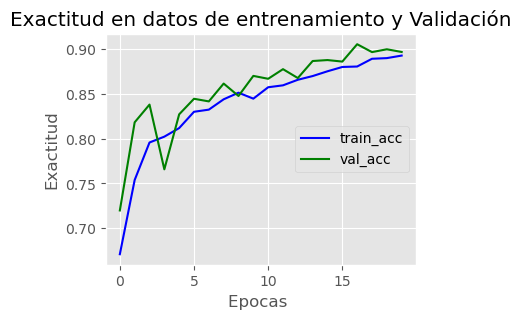

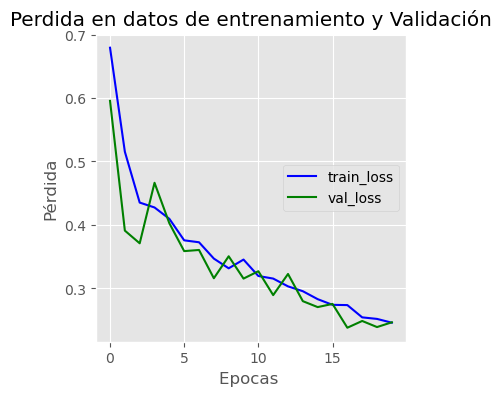

In [12]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(4,3))
plt.plot(np.arange(0,N), results.history["accuracy"], label="train_acc",color='b')
plt.plot(np.arange(0,N), results.history["val_accuracy"], label="val_acc",color='g')
plt.title("Exactitud en datos de entrenamiento y Validación")
plt.xlabel("Epocas ")
plt.ylabel("Exactitud")
plt.legend(loc="center right")
#plt.grid()
plt.savefig('GRAFICAS/EXACTITUD/'+str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))+'.jpg', bbox_inches='tight')
plt.show()

plt.style.use("ggplot")
plt.figure(figsize=(4,4))
plt.plot(np.arange(0,N), results.history["loss"], label="train_loss",color='b')
plt.plot(np.arange(0,N), results.history["val_loss"], label="val_loss",color='g')
plt.title("Perdida en datos de entrenamiento y Validación")
plt.xlabel("Epocas ")
plt.ylabel("Pérdida")
plt.legend(loc="center right")
#plt.grid()
plt.savefig('GRAFICAS/PERDIDA/'+str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))+'.jpg', bbox_inches='tight')
plt.show()

## 8. Probamos el modelo con las imágenes de prueba

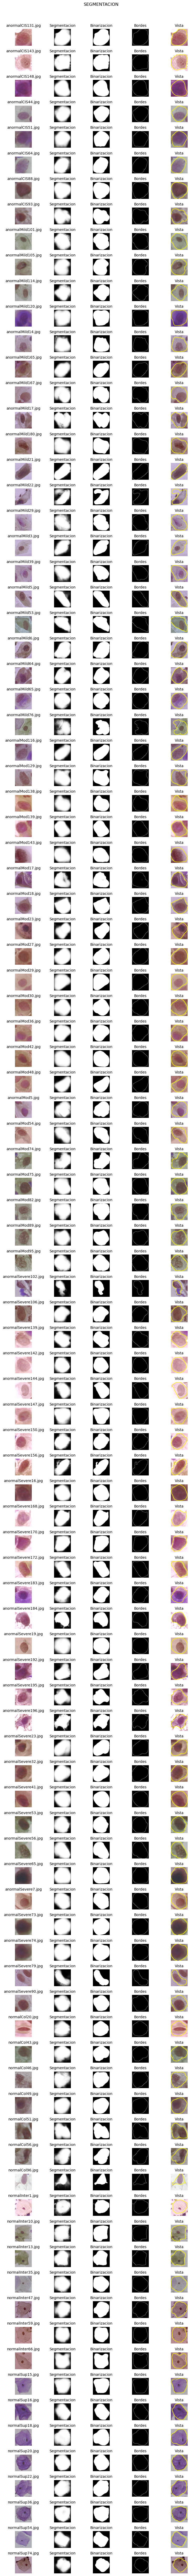

In [67]:
archivos = listaCelulasTest[0:]
segmentacion = model.predict(prueba)
columnas = ['1','2','3','4','5']
figure, ax = plt.subplots(len(archivos),len(columnas))
figure.set_size_inches(8,100)
figure.suptitle('SEGMENTACION')
for iter1,ele1 in enumerate(archivos):
    imagenPrueba = cv2.imread('PRUEBA/'+ele1)
    imagenSegmentada = segmentacion[iter1]

    #seg = segmentacion[0].copy()
    imgIn = imagenPrueba.copy()
    seg = imagenSegmentada.reshape(128,128)
    seg = Lambda(lambda x: x*255)(seg)
    seg = np.asarray(seg,dtype=np.uint8)
    # Aplicar filtro de mediana con kernel de 5x5
    gauss = cv2.medianBlur(seg,11)
    #binarizacion por el metodo de otsu
    ret3, bin = cv2.threshold(gauss,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Detectamos los bordes con Canny
    canny = cv2.Canny(bin, 10, 150)
    # Buscamos los contornos
    (contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print("He encontrado {} posibles nucleos".format(len(contornos)))
    cv2.drawContours(imgIn,contornos,-1,(255,255,0), 2)


    tipoImagen = [imagenPrueba,imagenSegmentada,bin,canny,imgIn]
    nombreColumna = [ele1,'Segmentacion','Binarizacion','Bordes','Vista']
    for k in range(0,len(columnas)):

        ax[iter1,k].imshow(tipoImagen[k],'gray')
        ax[iter1,k].set(title=nombreColumna[k])
        ax[iter1,k].title.set_size(10)
        ax[iter1,k].axis('off')

plt.tight_layout()

plt.subplots_adjust(top=0.97)

plt.show()


## Prueba con imagen de entrenamiento

In [10]:
segmentacion = model.predict(X)


posicion imagen: 854
He encontrado 1 posibles Citoplasma


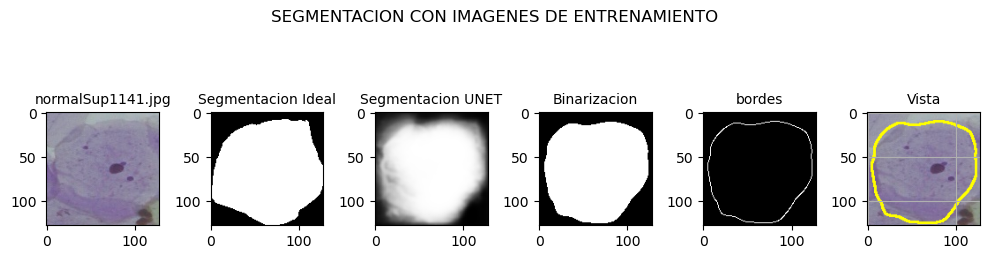

In [12]:
num = random.randint(10,1000)
print('posicion imagen:',num)
fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1, 6,figsize=(10,3))
fig.suptitle('SEGMENTACION CON IMAGENES DE ENTRENAMIENTO')
ax1.imshow(X[num],'gray')
ax1.set(title=listaCelulas[num])
ax1.title.set_size(10)
plt.grid()

ax2.imshow(Y[num],'gray')
ax2.set(title='Segmentacion Ideal')
ax2.title.set_size(10)
plt.grid()

ax3.imshow(segmentacion[num],'gray')
ax3.set(title='Segmentacion UNET')
ax3.title.set_size(10)
plt.grid()

seg = segmentacion[num].copy()
imgSeg = X[num].copy()
seg = seg.reshape(128,128)
seg = Lambda(lambda x: x*255)(seg)
seg = np.asarray(seg,dtype=np.uint8)
# Aplicar filtro de mediana con kernel de 5x5
gauss = cv2.medianBlur(seg,11)
#binarizacion por el metodo de otsu
ret3, gauss = cv2.threshold(gauss,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ax4.imshow(gauss,'gray')
ax4.set(title='Binarizacion')
ax4.title.set_size(10)

# Detectamos los bordes con Canny
canny = cv2.Canny(gauss, 10, 150)
ax5.imshow(canny,'gray')
ax5.set(title='bordes')
ax5.title.set_size(10)

 # Buscamos los contornos
(contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("He encontrado {} posibles Citoplasma".format(len(contornos)))
cv2.drawContours(imgSeg,contornos,-1,(255,255,0), 2)
ax6.imshow(imgSeg)
ax6.set(title='Vista')
ax6.title.set_size(10)
plt.tight_layout()

plt.show()

## Prueba con imagen particular

He encontrado 2 posibles Citoplasmas


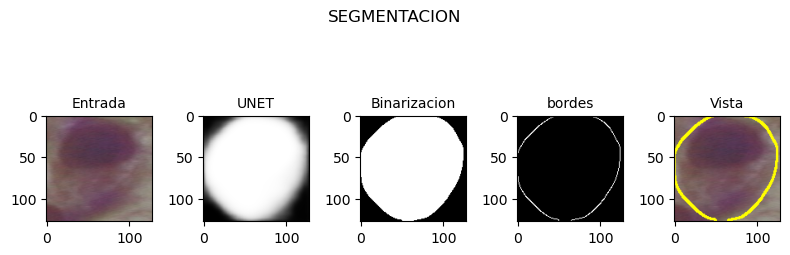

In [57]:
imagen = cv2.imread('CELULAS/normalCol69.jpg')[:,:,:3]
#imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
#imagen = cv2.resize(imagen,dsize=(128,128))
imagen2 = imagen.copy()
imagenT = np.array([imagen2,imagen2])
segmentacion = model.predict(imagenT)
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(8,3))

fig.suptitle('SEGMENTACION')
ax1.imshow(imagenT[0])
ax1.set(title='Entrada')
ax1.title.set_size(10)

ax2.imshow(segmentacion[0],'gray')
ax2.set(title='UNET')
ax2.title.set_size(10)

#seg = segmentacion[0].copy()
imgIn = imagen.copy()
seg = segmentacion[0].reshape(128,128)
seg = Lambda(lambda x: x*255)(seg)
seg = np.asarray(seg,dtype=np.uint8)
# Aplicar filtro de mediana con kernel de 5x5
gauss = cv2.medianBlur(seg,11)
#binarizacion por el metodo de otsu
ret3, gauss = cv2.threshold(gauss,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ax3.imshow(gauss,'gray')
ax3.set(title='Binarizacion')
ax3.title.set_size(10)

# Detectamos los bordes con Canny
canny = cv2.Canny(gauss, 10, 150)
ax4.imshow(canny,'gray')
ax4.set(title='bordes')
ax4.title.set_size(10)

 # Buscamos los contornos
(contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("He encontrado {} posibles Citoplasmas".format(len(contornos)))
cv2.drawContours(imgIn,contornos,-1,(255,255,0), 2)
ax5.imshow(imgIn)
ax5.set(title='Vista')
ax5.title.set_size(10)


plt.tight_layout()
plt.show()


(-0.5, 127.5, 127.5, -0.5)

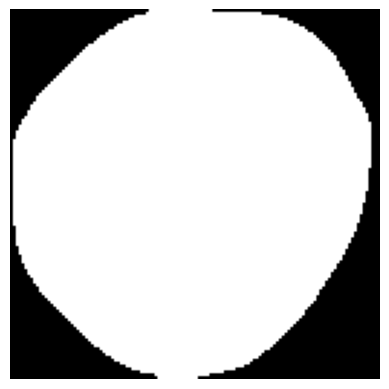

In [58]:
plt.imshow(gauss,'gray')
plt.axis(False)

# 10. Guardar y cargar el modelo para futuras pruebas

Se guarda el modelo entrenado juntos con sus pesos para uso futuro con diferentes imágenes. Esto se hace con el fin de no volver a entrenar la red, sino que usarla directamente sobre una nueva imagen

In [1]:
from tensorflow.keras.models import load_model

In [ ]:
# se guarda el modelo y sus pesos entrenados
model.save('unetCito2.h5')
model.save_weights('unetCitoPesos2.h5')

### Cargar el modelo

In [9]:
model = load_model('unetCito2.h5')
model.load_weights('unetCitoPesos2.h5')

100%|██████████| 9/9 [00:00<00:00, 43.48it/s]


imagenes de prueba: (9, 128, 128, 3)


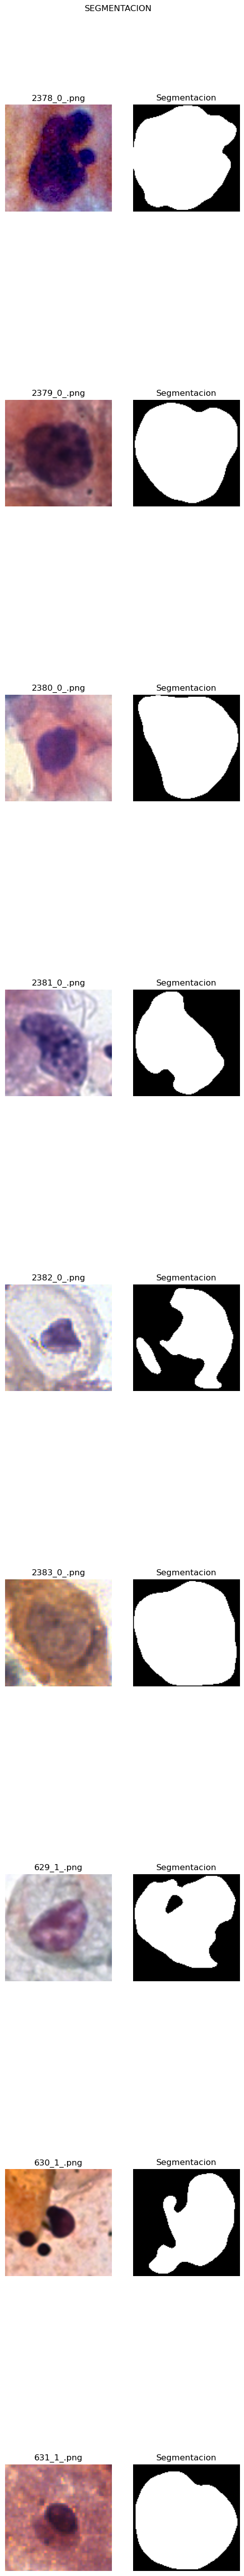

In [59]:
# PRUEBA CON MAS IMAGENES
listaAdicionales = os.listdir('ADICIONALES/')
adicionales= []
# recorremos las celulas de entrenamiento y las guardamos en un tensor
for celula in tqdm(listaAdicionales):
    imagen = cv2.imread('ADICIONALES/'+celula)[:,:,:3]
    imagen = cv2.resize(imagen,dsize=(128,128))
    adicionales.append(imagen)
adicionales = np.asarray(adicionales,dtype=np.uint8)
print('imagenes de prueba:',adicionales.shape)

archivos = listaAdicionales[0:]
segmentacion = model.predict(adicionales)
columnas = ['1','2']
figure, ax = plt.subplots(len(archivos),len(columnas))
figure.set_size_inches(6,60)
figure.suptitle('SEGMENTACION')
for iter1,ele1 in enumerate(archivos):
    imagenPrueba = cv2.imread('ADICIONALES/'+ele1)
    imagenSegmentada = segmentacion[iter1]
    imagenSegmentada = Lambda(lambda x: x*255)(imagenSegmentada)
    imagenSegmentada = np.asarray(imagenSegmentada,dtype=np.uint8)
    # Aplicar filtro de mediana con kernel de 5x5
    imagenSegmentada = cv2.medianBlur(imagenSegmentada,11)
    #binarizacion por el metodo de otsu
    ret3, imagenSegmentada = cv2.threshold(imagenSegmentada,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    tipoImagen = [imagenPrueba,imagenSegmentada]
    nombreColumna = [ele1,'Segmentacion']
    for k in range(0,len(columnas)):

        ax[iter1,k].imshow(tipoImagen[k],'gray')
        ax[iter1,k].set(title=nombreColumna[k])
        ax[iter1,k].axis('off')
#figure.tight_layout()

plt.subplots_adjust(top=0.97)

plt.show()

In [ ]:
imagen = cv2.imread('imagen.jpg')[:,:,:3]
#imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
imagen = cv2.resize(imagen,dsize=(128,128))
imagen2 = imagen.copy()
imagenT = np.array([imagen,imagen2])
segmentacion = cnn.predict(imagenT)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6,3))

fig.suptitle('SEGMENTACION')
ax1.imshow(imagenT[0])
ax2.imshow(segmentacion[0])